In this file, I will analyze the data from three events, "Father's day", "BBQ and pool parties" and "Pet parties".

In [1]:
# Import necessary libraries

import pandas as pd
pd.set_option('display.max_columns', 500) # To see more columns in pandas dataframes
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import json
import os
from pandas.io.json import json_normalize
import datetime


In [2]:
# Reading the events and guests files from CSV
# Rename 'host_id' feature into 'user_id' in events files to match th guests files

events_Fathers_Day_df = pd.read_csv('events_Fathers_Day.csv').rename(columns={'host_id': 'user_id'})
guests_host_Fathers_Day_df = pd.read_csv('guests_host_Fathers_Day.csv')

events_BBQ_Day_df = pd.read_csv('events_BBQ_Pool_Party.csv', encoding = "ISO-8859-1").rename(columns={'host_id': 'user_id'})
guests_host_BBQ_Day_df = pd.read_csv('guests_host_BBQ_Pool_Party.csv')

events_Pet_Day_df = pd.read_csv('events_Pet_Parties.csv').rename(columns={'host_id': 'user_id'})
guests_host_Pet_Day_df = pd.read_csv('guests_host_Pet_Parties.csv')

# Append data for all three events together into a single events and single guests files.
events_df = events_Fathers_Day_df.append(events_BBQ_Day_df)
events_df = events_df.append(events_Pet_Day_df)

guests_host_df = guests_host_Fathers_Day_df.append(guests_host_BBQ_Day_df)
guests_host_df = guests_host_df.append(guests_host_Pet_Day_df)

# Delete the original dataframes to save space
del [events_Fathers_Day_df, guests_host_Fathers_Day_df, events_BBQ_Day_df, guests_host_BBQ_Day_df, events_Pet_Day_df, guests_host_Pet_Day_df]

print('done')

C:\Users\Leo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


done


In [3]:
print('there are ', events_df['event_id'].nunique(), ' unique events')
print('there are ', guests_host_df['user_id'].nunique(), ' unique users')
print('total size of events_df = ', events_df.shape[0])
print('total size of guests_host_df = ', guests_host_df.shape[0])

print('done')

there are  525300  unique events
there are  8222685  unique users
total size of events_df =  525300
total size of guests_host_df =  11080614
done


In [4]:
# perform some cleaning
# Simply remove all the rows with missing values. Can be optimized later to fill in those values instead
events_df.dropna(inplace = True)

# correct dates with unreasonable years in events dataframe
# I found these by events_df['event_date'].apply(lambda x: int(str(x)[:4]) > 2019)
# There were only two such entries, so I'm fixing them manually.
# They can be either removed or fixed automatically for a larger dataset.
events_df['event_date'].loc[140147] = '2018-11-27 17:12:00'
events_df['event_date'].loc[341903] = '2018-07-01 15:00:00'


good_dates = guests_host_df['event_date'].apply(lambda x: int(str(x)[:4]) < 2050)
guests_host_df = guests_host_df[good_dates]


# there were approximately 200 rows with strange years in guests dataframe.
# They were most likely wrong, so I'll just remove them.
# It is unlikely that anyone planned events so far ahead.
good_dates = guests_host_df['event_date'].apply(lambda x: int(str(x)[:4]) < 2050)
guests_host_df = guests_host_df[good_dates]

# There was a single row where the number of guests was some kind of a word instead of a number.
# So I'll just remove this row.
events_df.drop(index=106313, inplace = True)


# some rows have guests number as words instead of a float. removing those numbers
def help_funct_4(x):
    try:
        a = float(x)
        return True
    except ValueError:
        return False
    
events_df = events_df[events_df['guests'].apply(lambda x: help_funct_4(x))]

print('done')

done


Next, I'll perform some feature engineering.

In [5]:
# Calculate the frequency of attending events for each user.
# "hosts_with_earliest_event_date_df" contains id of each host with the earliest date they hosted an event
temp = events_df[['event_date','user_id']]
hosts = temp.groupby('user_id', as_index=False).agg({'event_date':['min','max','count']}).rename(columns={'event_date': 'host_events_date'})

# "all_users_with_earliest_event_date_df" will contain information of users with an earliest even they attended, including as a guest
temp = guests_host_df[['event_date','user_id']]
all_guest_events = temp.groupby('user_id', as_index=False).agg({'event_date':['min','max','count']}).rename(columns={'event_date': 'all_events_date'})

del temp

print('done')

done


In [6]:
# calculate the number of days between first and last attended event 
all_guest_events['timeDel_first_last'] = (pd.to_datetime(all_guest_events['all_events_date']['max'])
                                               - pd.to_datetime(all_guest_events['all_events_date']['min'])).astype('timedelta64[D]')


In [7]:
# calculate the inverse frequency of attending the events for each user
all_guest_events['inv_freq_attending'] = all_guest_events['timeDel_first_last']/all_guest_events['all_events_date']['count']

In [8]:
# change colomn names and levels in hosts and all_guest_events for convinience

hosts.columns = [' '.join(col) for col in hosts.columns]
all_guest_events.columns = [' '.join(col) for col in all_guest_events.columns]

hosts.rename(columns={'user_id ': 'user_id'}, inplace = True)
all_guest_events.rename(columns={'user_id ': 'user_id'}, inplace = True)

In [9]:
# determine the guests who turned into the hosts.

merged_data = pd.merge(hosts, all_guest_events,\
         on = 'user_id')
merged_data['guest2host'] = (merged_data['host_events_date min'] > merged_data['all_events_date min']).astype(int)

guest_turned_host = merged_data['guest2host'].astype(int)
# by running merged_data['guest2host'].sum() you get the number of guests who turned into hosts as 198.
# the number will be higher once we use the full dataset instead of using data from just three events.

In [10]:
all_guest_events.head()

,user_id,all_events_date min,all_events_date max,all_events_date count,timeDel_first_last,inv_freq_attending
0,0000007ea98ed7442fc107bad2a44b8f,2016-06-18 16:00:00,2016-06-18 16:00:00,1,0.0,0.0
1,000000be05b84451ba9d619ffe7d088d,2016-11-05 16:00:00,2016-11-05 16:00:00,1,0.0,0.0
2,0000036d6c6b3eba5fbd60e346c9cf76,2015-11-04 16:30:00,2015-11-04 16:30:00,1,0.0,0.0
3,000003a423b82ecc73feda0a4dfececd,2016-06-12 16:30:00,2016-06-12 16:30:00,1,0.0,0.0
4,000003c6366ef83266c95276d94cf8ec,2018-06-10 15:00:00,2018-06-10 15:00:00,1,0.0,0.0


In [11]:
# merge the table with guests who turned into hosts in events_Fathers_Day_df to get a guest2host feature.
# merge them using "user_id"
# I'm using merge left so that the indexing is done on events.

events_df = pd.merge(events_df,merged_data[['user_id','guest2host']],how='left',on = 'user_id')
events_df.head()

,event_id,user_id,event_type,event_category,correspondence,event_category_group,seasonal,event_date,sent_on,created_date,location,zip,premium_vs_free,template_name,guests,rsvp_yes,rsvp_no,rsvp_maybe,rsvp_undecided,search_term,guest2host
0,006f2177baa513f690545a8536b1f7a4,e5d77a5da3b8d0091f5bd2f858d0e21e,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 15:00:00,2016-06-13 19:19:27,2016-06-13 19:19:26.69081,Unidentified,90815,Free,fathersdayframe,9,5,0,0,4,father's+day,NaN
1,00d64d55efc68302bd37c985781007ed,79c19c038588e8d877c3dd42ced2d932,fathers_day,Fathers Day,f,Fathers Day,t,2018-06-16 19:00:00,2018-05-18 20:35:10,2018-05-18 20:29:35.26702,Home,77087,Free,onecooldude,64,19,6,5,34,retirement,1.0
2,020493fd68f615f780bfecbd09ea57f0,1392a91d246d1a4f4ab3b8fbe8edc467,fathers_day,Fathers Day,f,Fathers Day,t,2017-06-18 13:30:00,2017-06-11 20:53:30,2017-06-11 20:52:01.43312,Home,90703,Free,bowtie,5,3,0,0,2,Father's+Day,1.0
3,00929e161da3774494fb58f534d3c5e6,323a5fda9d2a17a9f905e9a6b21df601,fathers_day,Fathers Day,f,Fathers Day,t,2017-06-18 08:00:00,2017-06-12 23:16:12,2017-06-12 23:15:07.9046,Home,60541,Free,topspops,5,2,0,0,3,father's day,1.0
4,033d2916d652480d1864a0dcb56fb729,a5e6ab1830098a402b802f9f6c964e7d,fathers_day,Fathers Day,f,Fathers Day,t,2018-06-17 10:00:00,2018-06-14 14:13:00,2018-06-14 14:11:00.196576,Unidentified,92102,Free,celebratedad,21,3,0,0,18,father's+day,0.0


In [12]:
# perform a similar merge for the guests dataframe
guests_host_df = pd.merge(guests_host_df,merged_data[['user_id','guest2host']],how='left',on = 'user_id')

In [13]:
# I will remove rows with non-US zip codes.
# I will keep rows with missing zip codes and fill them up with 00000 instead.
# This might introduce a small error for rows which might be from non-US events, but it should be fine since 
# most of the events are from the US anyway

import re
# b = re.compile(r"^\d{5}$") # this would match a 5 digit code only!
b = re.compile(r"^\d{5}") # this option keeps rows with 9 digit codes too, but reduced the zip code to the first 5 digits.

# replace na in zip code with 00000
events_df['zip'].fillna('00000',inplace = True)

filter = events_df['zip'].str.match(b)
events_df = events_df[events_df['zip'].str.contains(b) == True]

# retain events with 5 or more digit zip only
events_with_zip = events_df[events_df['zip'].str.contains(b) == True]
events_with_zip['zip'] = events_with_zip['zip'].apply(lambda x: x[:5])

events_with_zip['guests'] = events_with_zip['guests'].astype(int)

In [14]:
# create new features using the zip code
# count the total number of guests for all events for each zip code, as well as the average number of guests for events for each zip code

grouped = events_with_zip.groupby('zip', as_index = False).agg({'guests' : ['count', 'mean']})
grouped.columns = ['_'.join(col) for col in grouped.columns]
grouped.rename(columns={'zip_': 'zip'}, inplace = True)
grouped.head()

,zip,guests_count,guests_mean
0,00000,4,33.0
1,00199,1,4.0
2,00716,1,38.0
3,00795,1,11.0
4,00959,1,8.0


In [15]:
# fill up missing 'guest2host' features with 0s
events_df['guest2host'].fillna(0,inplace = True)
guests_host_df['guest2host'].fillna(0,inplace = True)

In [16]:
# calculate the number of days between sent_on and event_date
events_df['event_vs_sent'] = (pd.to_datetime(events_df['event_date'])
                                               - pd.to_datetime(events_df['sent_on'])).astype('timedelta64[D]')


In [17]:
temp = events_df[['event_id','user_id']].groupby('user_id', as_index=False).agg('count').rename(columns={'event_id': 'host_event_number'})
events_df = pd.merge(events_df,temp,on = 'user_id')
events_df.head()

,event_id,user_id,event_type,event_category,correspondence,event_category_group,seasonal,event_date,sent_on,created_date,location,zip,premium_vs_free,template_name,guests,rsvp_yes,rsvp_no,rsvp_maybe,rsvp_undecided,search_term,guest2host,event_vs_sent,host_event_number
0,006f2177baa513f690545a8536b1f7a4,e5d77a5da3b8d0091f5bd2f858d0e21e,fathers_day,Fathers Day,f,Fathers Day,t,2016-06-19 15:00:00,2016-06-13 19:19:27,2016-06-13 19:19:26.69081,Unidentified,90815,Free,fathersdayframe,9,5,0,0,4,father's+day,0.0,5.0,2
1,a25988c5a90ce6e6653725a24842161c,e5d77a5da3b8d0091f5bd2f858d0e21e,pool_party,Pool Party,f,BBQ-Pool Party,t,2016-06-15 12:00:00,2016-05-13 13:11:47,2016-05-13 13:11:47.10083,Unidentified,90815,Free,splashy,26,13,3,1,9,pool+party,0.0,32.0,2
2,00d64d55efc68302bd37c985781007ed,79c19c038588e8d877c3dd42ced2d932,fathers_day,Fathers Day,f,Fathers Day,t,2018-06-16 19:00:00,2018-05-18 20:35:10,2018-05-18 20:29:35.26702,Home,77087,Free,onecooldude,64,19,6,5,34,retirement,1.0,28.0,1
3,020493fd68f615f780bfecbd09ea57f0,1392a91d246d1a4f4ab3b8fbe8edc467,fathers_day,Fathers Day,f,Fathers Day,t,2017-06-18 13:30:00,2017-06-11 20:53:30,2017-06-11 20:52:01.43312,Home,90703,Free,bowtie,5,3,0,0,2,Father's+Day,1.0,6.0,1
4,00929e161da3774494fb58f534d3c5e6,323a5fda9d2a17a9f905e9a6b21df601,fathers_day,Fathers Day,f,Fathers Day,t,2017-06-18 08:00:00,2017-06-12 23:16:12,2017-06-12 23:15:07.9046,Home,60541,Free,topspops,5,2,0,0,3,father's day,1.0,5.0,1


In [18]:
num_columns = ['guests','rsvp_yes','event_vs_sent','host_event_number']

# make sure that the numerical columns are float type
for col in num_columns:
    events_df[col] = events_df[col].astype(float)

print('done')

done


In [19]:
# calculate rsvp_yes over total # of guests ratio

events_df['rsvp_vs_sent'] = 1.0 * events_df['rsvp_yes']/events_df['guests']
num_columns = num_columns + ['rsvp_vs_sent']

In [20]:
#zip-income table
from uszipcode import SearchEngine,Zipcode
search = SearchEngine(simple_zipcode=True)
result = search.by_median_household_income(returns=0)
#to specify range,use lower/upper = ""
#result = search.by_median_household_income(lower=100000,upper=150000,returns=0)
#output to lists
zip_list = []
income_list = []

for zipcode in result:
    zip_list.append(zipcode.to_dict()['zipcode'])
    income_list.append(zipcode.to_dict()['median_household_income'])
    #rent_list.append(zipcode.to_dict()['monthly_rent_including_utilities_3plus_b'])
#convert to df
zip_df = pd.DataFrame({
    'zipcode':zip_list,
    'median_household_income':income_list
})

In [21]:
zip_df.rename(columns = {'zipcode': 'zip'}, inplace = True)
zip_df.tail()

,zip,median_household_income
28842,13834,2499
28843,97331,2499
28844,79916,2499
28845,98536,2499
28846,99144,2499


In [22]:
# merge the median household income information with the events dataframe

events_df = pd.merge(events_df,zip_df[['zip','median_household_income']],how='left',on = 'zip')


In [23]:
# add median_household_income to numerical features list
num_columns = num_columns + ['median_household_income']

In [24]:
# make sure that the categorical features are indeed categorical
cat_columns = ['event_type','correspondence','seasonal','zip','premium_vs_free']
for c in cat_columns:
    events_df[c] = events_df[c].astype('category')

In [25]:
# define training dataframe using the numerical and categorical features

train_df = events_df[cat_columns+num_columns]
train_df.head()

,event_type,correspondence,seasonal,zip,premium_vs_free,guests,rsvp_yes,event_vs_sent,host_event_number,rsvp_vs_sent,median_household_income
0,fathers_day,f,t,90815,Free,9.0,5.0,5.0,2.0,0.555556,82805.0
1,pool_party,f,t,90815,Free,26.0,13.0,32.0,2.0,0.500000,82805.0
2,fathers_day,f,t,77087,Free,64.0,19.0,28.0,1.0,0.296875,38707.0
3,fathers_day,f,t,90703,Free,5.0,3.0,6.0,1.0,0.600000,89113.0
4,fathers_day,f,t,60541,Free,5.0,2.0,5.0,1.0,0.400000,76875.0


In [26]:
# devide the data into training and testing datasets
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    train_df[cat_columns + num_columns], events_df['guest2host'], test_size=0.33, random_state=42)

In [27]:
# Set fixed params
params_classification = {#"objective" : "regression",
        "metric" : "rmse",
        'max_depth' : -1,
        'max_bin': 512,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1,
        "is_unbalance" : True}

# Create parameters to search
gridParams_classification = {
    "bagging_fraction" : [0.1, 0.2, 0.3],
    "min_child_samples" : [200, 300, 500], #50, 100, 200, 300, 500
    'learning_rate': [0.05], #0.1, 0.05, 0.2
    'n_estimators': [40], # 10, 20, 40, 70, 100
    'num_leaves': [50], # 30, 50, 70
    'colsample_bytree': [0.1], # 0.1, 0.3, 1
    #'subsample': [0.01, 0.1], # 0.1, 0.3, 1
    'reg_alpha': [1], # 1, 1.2, 1.4
    'reg_lambda': [1.2], # 1, 1.2, 1.4
    }



In [28]:
# Create classifier to use. Note that parameters have to be input manually, not as a dict!

mdl_classifier = lgb.LGBMClassifier(
          objective = 'binary',
          n_jobs = 3,
          silent = True,
          max_depth = params_classification['max_depth'],
          max_bin = params_classification['max_bin'],
          feature_fraction = params_classification['feature_fraction']#,
          #min_child_samples = params_classification['min_child_samples'],
          #bagging_fraction = params_classification['bagging_fraction']
          )

In [29]:
# Create the grid search with 4 fold cross validation
grid_classification = GridSearchCV(mdl_classifier, gridParams_classification,
                    verbose=0,
                    cv=5,
                    n_jobs=2)

In [30]:
# Run the grid
grid_classification.fit(X_train_df, y_train_df)

# Print the best parameters found
print(grid_classification.best_params_)
print(grid_classification.best_score_)

{'bagging_fraction': 0.1, 'colsample_bytree': 0.1, 'learning_rate': 0.05, 'min_child_samples': 300, 'n_estimators': 40, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 1.2}
0.7282322623094638


In [31]:
# check the quality of calculation
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_train_df, grid_classification.predict_proba(X_train_df)[:,1]))
print('rms = ', rms)

from sklearn.metrics import accuracy_score
accur = accuracy_score(y_train_df, grid_classification.predict(X_train_df))
print('accuracy = ', accur)

rms =  0.4317106939598985
accuracy =  0.7288353986182695


C:\Users\Leo\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [32]:
# draw the ROC curve

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test_df, grid_classification.predict_proba(X_test_df)[:,1])

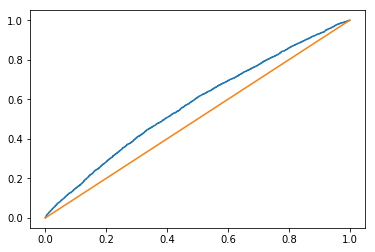

In [33]:
# draw the ROC curve

plt.figure()
lw = 2
x = [0, 1]
y = [0, 1]
plt.plot(fpr, tpr)
plt.plot(x, y)


In [34]:
guests_host_df[['event_id','rsvp_response']].head()

,event_id,rsvp_response
0,00008491c4487cd5089303e890a2d723,undecided
1,00008491c4487cd5089303e890a2d723,undecided
2,00008491c4487cd5089303e890a2d723,yes
3,00008491c4487cd5089303e890a2d723,yes
4,00008491c4487cd5089303e890a2d723,yes
